## Basic concept
#### Environment -(observation)-> Agent -(policy)-> Reward -(Change of policy)-> Environment ...
_____________________________________________________________________________________________________________________________________________
### The algorithm a software uses to determine its actions is called its policy.
### Action = policy(observation)
_____________________________________________________________________________________________________________________________________________

#### Policy search:
1. **Brute force approach** = try every single parameter and grade
2. **Genetic algorithms** = Start with 100 random policies. Make 10 copies of the 10 best and add some random variations... repeat good result
3. **Policy gradients** = Maximize reward(parameters)

_____________________________________________________________________________________________________________________________________________

Exploitation / exploration dilemma
_____________________________________________________________________________________________________________________________________________

#### Credit assignment problem solution == "Planning"
- **Evaluate an action based on the sum of all rewards that come after it**
- **goodness_of_action = return = sum(weight_i * reward_i)** , i=0,..,n
- **gamma parameter: weight_i = gamma^i**
- **gamma in (0,1)**
- gamma ~ 0 "Not much thinking ahead - think of just the next move"
- gamma = 1 "Every next step is as significant"

A formula for gamma\
**gamma = (0.5)^(1/steps_ahead)**, that way steps_ahead move will count as much as half of the first move
_____________________________________________________________________________________________________________________________________________
**Action advantage: Adv_i**
- **Run many episodes and calculate the average return of all steps and actions**
- **Adv_i = (return_i - mean)/std of i'th action**
- Good actions: Adv>0. Bad actions: Adv<0
________________________________________________________________________________________________________________________________________


In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
env = gym.make('CartPole-v1' , render_mode = 'rgb_array')
env.action_space

Discrete(2)

In [20]:
obs , info = env.reset(seed = 42)
obs # x , dot_x , θ , dot_θ

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

### Visualization

/Users/User/.local/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(array([-0.03963102,  0.24230015,  0.0266861 , -0.25572422], dtype=float32),
 1.0,
 False,
 False)

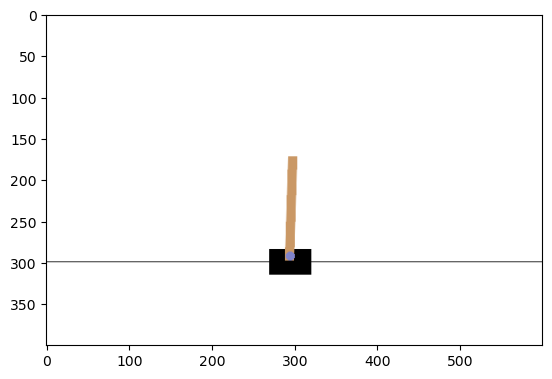

In [6]:
obs , info = env.reset()
obs , reward , done , truncated , info = env.step(1)
img = env.render()
plt.imshow(img)
obs , reward , done , truncated 

### Poicy example (Non trainable)

In [7]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(100):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break
            
    totals.append(episode_rewards)

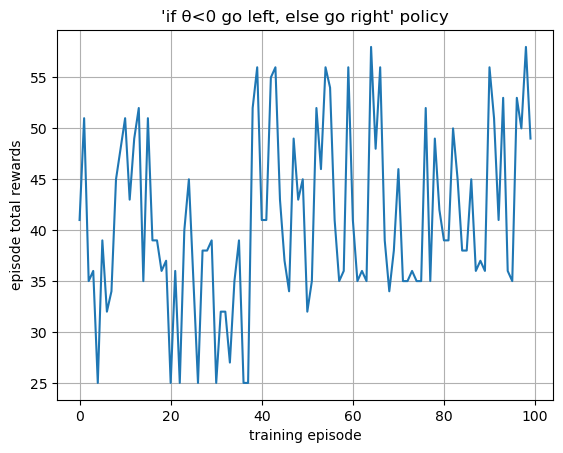

In [8]:
plt.plot(totals)
plt.xlabel('training episode')
plt.ylabel('episode total rewards')
plt.title("'if θ<0 go left, else go right' policy")
plt.grid()

### Neural net

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(6,activation = 'relu'),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
])

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy


# outputs the probability of going left

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Policy gradient algorithm (1992)
1. **Play several times. At each step compute the gradients that would make the chosen action even more likely (don't apply yet)**
2. **Compute each action's advantage**
3. **Multiply each gradient vector by the action's advantage**
4. **Perform gradient descent with the mean of all these gradient vectors**

In [11]:
# action basically
def play_one_step(env , obs , model , loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis]) # hard coded
        action = (tf.random.uniform([1,1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action , tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target , left_proba)) # this will make the chosen action even more likely
    grads = tape.gradient(loss , model.trainable_variables)
    obs , reward , done , truncated , info = env.step(int(action))
    return obs , reward , done , truncated , grads

In [12]:
# multiple actions
def play_multiple_episodes(env , n_episodes , n_max_steps , model , loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs , info = env.reset()
        for step in range(n_max_steps):
            obs , reward , done, truncated , grads = play_one_step(env , obs , model , loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards , all_grads
# returns a reward matrix = (reward per step) for every episode (episode)
# returns a gradient matrix = (one gradient tensor per trainable variable) per (tuple of gradients per step) for every episode

In [13]:
# Advantage
def discount_rewards(rewards,discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2 , -1 , -1): #backward to zero
        discounted[step] += discounted[step+1]*discount_factor # all weighted equally
    return discounted
 
def discount_and_normalize_rewards(all_rewards,discount_factor):
    all_discounted_rewards = [discount_rewards(rewards , discount_factor) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean() # of all rewards of each step of each episode (discounted-planning)
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

In [14]:
# example - advantage
discount_and_normalize_rewards([ [10,0,-50] , [10,20] ],discount_factor = 0.8) 

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [17]:
# hyperparameters
n_iterations = 20
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.99

In [18]:
# training loop
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env,n_episodes_per_update,n_max_steps,model,loss_fn) #step 1
    all_final_rewards = discount_and_normalize_rewards(all_rewards,discount_factor) # step 2
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)): # step 3
        mean_grads = tf.reduce_mean([final_reward * all_grads[episode_index][step][var_index]
                                     for episode_index , final_rewards in enumerate(all_final_rewards)
                                     for step, final_reward in enumerate(final_rewards)],axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads,model.trainable_variables)) # step 4

In [19]:
# testing
env = gym.make('CartPole-v1' , render_mode = 'rgb_array')
R = []
for episode in range(10):
    state , _ = env.reset(seed = episode)
    done = False
    rewards = 0
    for step in range(n_max_steps):
        env.render()
        action = round(1-model(state[np.newaxis]).numpy()[0,0])
        next_state , reward ,done,truncated,info = env.step(action)
        state = next_state
        rewards += reward
        if done or truncated:
            env.render()
            break
    print('Finished episode', episode, 'with reward', rewards)
    R.append(rewards)
R = np.array(R)
env.close()
np.mean(R) , np.std(R)
#reward = +1 for every step

Finished episode 0 with reward 200.0
Finished episode 1 with reward 200.0
Finished episode 2 with reward 200.0
Finished episode 3 with reward 200.0
Finished episode 4 with reward 200.0
Finished episode 5 with reward 200.0
Finished episode 6 with reward 200.0
Finished episode 7 with reward 200.0
Finished episode 8 with reward 200.0
Finished episode 9 with reward 200.0


(200.0, 0.0)

In [25]:
x = tf.convert_to_tensor(np.array([1.0 , 2.3 , 53.2 , 12, 232 , 2121, 121])[np.newaxis])
model(obs[np.newaxis])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4261747]], dtype=float32)>

### EOF